In [1]:
import os
import sys
import pickle
import time

PROJECT_ROOT = os.path.abspath('..')
sys.path.append(PROJECT_ROOT)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import pandas as pd
import scipy
from scipy import stats
from tqdm import tqdm

from sleeprnn.helpers.reader import load_dataset
from sleeprnn.common import constants, viz, pkeys
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection.predicted_dataset import PredictedDataset
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import det_utils
from figs_thesis import fig_utils

viz.notebook_full_width()

param_filtering_fn = fig_utils.get_filtered_signal_for_event
param_frequency_fn = fig_utils.get_frequency_by_fft
param_amplitude_fn = fig_utils.get_amplitude_event

RESULTS_PATH = os.path.join(PROJECT_ROOT, 'results')
LETTERS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

In [2]:
def load_predictions(parts_to_load, dataset, thr=0.5, verbose=True):
    if thr == 0.5:
        extra_str = ''
    else:
        extra_str = '_%1.2f' % thr
    pred_objects = []
    for part in parts_to_load:
        filepath = os.path.join(
            RESULTS_PATH, 'predictions_nsrr_ss',
            'ckpt_20210716_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_ensemble_to_e1_n2_train_nsrr_ss',
            'v2_time',
            'prediction%s_part%d.pkl' % (extra_str, part)
        )
        with open(filepath, 'rb') as handle:
            pred_object = pickle.load(handle)
        pred_object.set_parent_dataset(dataset)
        pred_objects.append(pred_object)
    return pred_objects


def extract_pages_for_stamps_strict(stamps, pages_indices, page_size):
    """Returns stamps that are at completely contained on pages."""
    stamps_start_page = np.floor(stamps[:, 0] / page_size)
    stamps_end_page = np.floor(stamps[:, 1] / page_size)
    useful_idx = np.where(
        np.isin(stamps_start_page, pages_indices) & np.isin(stamps_end_page, pages_indices)
    )[0]
    pages_data = stamps[useful_idx, :]
    return pages_data


def get_logit(x):
    return np.log(x / (1-x))


def get_proba(l):
    return 1 / (1 + np.exp(-l))

# Load NSRR dataset and pre-computed predicted dataset

In [ ]:
parts_to_load = [0] # 0 to 11

nsrr = load_dataset(constants.NSRR_SS_NAME, load_checkpoint=True, params={pkeys.PAGE_DURATION: 30})
pred_objects_1 = load_predictions(parts_to_load, nsrr)
pred_objects_0 = load_predictions(parts_to_load, nsrr, thr=0.25)

# Compute features

In [3]:
# Filenames of dataset checkpoints
byevent_proba_ckpt_path = os.path.join(
    RESULTS_PATH, 'predictions_nsrr_ss',
    'ckpt_20210716_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_ensemble_to_e1_n2_train_nsrr_ss',
    'v2_time',
    'table_byevent_proba.csv'
)

In [4]:
params_load_checkpoint = True

# ############################

if params_load_checkpoint:
    print("Loading from checkpoint")
    table_byevent_proba = pd.read_csv(byevent_proba_ckpt_path)
    # Change 64 bits dtypes to 32 bits to save memory
    int_cols = ["female", "center_sample", "prediction_part", "category"]
    float_cols = [col for col in table_byevent_proba.columns if col not in int_cols+["subject_id"]]
    table_byevent_proba[int_cols] = table_byevent_proba[int_cols].astype(np.int32)
    table_byevent_proba[float_cols] = table_byevent_proba[float_cols].astype(np.float32)
    print("Done.")
else:
    # Perform computation and save checkpoint
    
    bands_for_mean_power = [
        (0, 2),
        (2, 4),
        (4, 8),
        (8, 10),
        (11, 16),
        (16, 30),
        (4.5, 30),
    ]

    table_byevent_proba = {
        'subject_id': [],
        'age': [],
        'female': [],
        'center_sample': [],
        'prediction_part': [],
        'category': [],
        'probability': [],
        'duration': [], 
        'frequency': [],
        'amplitude_pp': [],
        'amplitude_rms': [],
        'correlation': [],
        'covariance': [],
        'c10_density_real': [],
        'c10_density_all': [],
        'c10_abs_sigma_power': [],
        'c10_rel_sigma_power': [],
        'c10_abs_sigma_power_masked': [],
        'c10_rel_sigma_power_masked': [],
        'c20_density_real': [],
        'c20_density_all': [],
        'c20_abs_sigma_power': [],
        'c20_rel_sigma_power': [],
        'c20_abs_sigma_power_masked': [],
        'c20_rel_sigma_power_masked': [],
    }
    table_byevent_proba.update(
        {'mean_power_%s_%s' % band: [] for band in bands_for_mean_power}
    )

    min_n2_minutes = 60
    verbose_min_minutes = False

    start_time = time.time()
    print("Generating table of parameters")
    n_parts = len(pred_objects_1)
    for part_id in range(n_parts):
        predictions_1 = pred_objects_1[part_id]
        predictions_0 = pred_objects_0[part_id]
        print("Processing Part %d / %d" % (part_id + 1, n_parts))
        
        n_subjects = 5 # len(predictions_1.all_ids)
        
        for i_subject in tqdm(range(n_subjects)):
            subject_id = predictions_1.all_ids[i_subject]
            n2_pages = predictions_1.data[subject_id]['n2_pages']
            n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
            if n2_minutes < min_n2_minutes:
                if verbose_min_minutes:
                    print("Skipped by N2 minutes: Subject %s with %d N2 minutes" % (subject_id, n2_minutes))
                continue

            marks_1 = predictions_1.get_subject_stamps(subject_id)  # Class 1 spindles (real)
            marks_0 = predictions_0.get_subject_stamps(subject_id)  # Class 0 "spindles" (false)
            # Let only those class 0 without intersecting class 1
            # If marks_1.size = 0 then marks_0 is by definition not intersecting
            if marks_1.size > 0:
                ov_mat = utils.get_overlap_matrix(marks_0, marks_1)
                is_intersecting = ov_mat.sum(axis=1)
                marks_0 = marks_0[is_intersecting == 0]
            if (marks_1.size + marks_0.size) == 0:
                continue  # There are no marks to work with
            
            # Now only keep N2 stage marks
            n2_pages = predictions_1.data[subject_id]['n2_pages']
            page_size = int(nsrr.fs * nsrr.original_page_duration)
            if marks_1.size > 0:
                marks_1 = extract_pages_for_stamps_strict(marks_1, n2_pages, page_size)
            if marks_0.size > 0:
                marks_0 = extract_pages_for_stamps_strict(marks_0, n2_pages, page_size)
            if (marks_1.size + marks_0.size) == 0:
                continue  # There are no marks to work with
                
            marks = []
            marks_class = []
            if marks_1.size > 0:
                marks.append(marks_1)
                marks_class.append([1] * marks_1.shape[0])
            if marks_0.size > 0:
                marks.append(marks_0)
                marks_class.append([0] * marks_0.shape[0])
            marks = np.concatenate(marks, axis=0).astype(np.int32)
            marks_class = np.concatenate(marks_class).astype(np.int32)
            n_marks = marks.shape[0]
            
            # Extract proba
            subject_proba = predictions_1.get_subject_probabilities(subject_id, return_adjusted=False)
            marks_proba = det_utils.get_event_probabilities(marks, subject_proba, downsampling_factor=8, proba_prc=75)
            marks_proba = marks_proba.astype(np.float32)
            # Extract signal
            subject_data = nsrr.read_subject_data(subject_id, exclusion_of_pages=False)
            signal = subject_data['signal'].astype(np.float64)
            age = float(subject_data['age'].item())
            female = int(subject_data['sex'].item() == 'f')
            
            # Parameters
            be_duration = (marks[:, 1] - marks[:, 0] + 1) / nsrr.fs

            filt_signal = param_filtering_fn(signal, nsrr.fs, constants.SPINDLE).astype(np.float64)
            signal_events = [filt_signal[e[0]:(e[1]+1)] for e in marks]

            be_amplitude_pp = np.array([
                param_amplitude_fn(s, nsrr.fs, constants.SPINDLE) for s in signal_events
            ])
            
            be_amplitude_rms = np.array([
                np.sqrt(np.mean(s ** 2)) for s in signal_events
            ])

            be_frequency = np.array([
                param_frequency_fn(s, nsrr.fs) for s in signal_events
            ])
            
            # New parameters
            signal_raw_events = [signal[e[0]:(e[1]+1)] for e in marks]
            
            # Measure mean power
            for band in bands_for_mean_power:
                table_byevent_proba['mean_power_%s_%s' % band].append([])
            for s in signal_raw_events:
                freq, power = fig_utils.get_fft_spectrum(s, nsrr.fs, pad_to_duration=10, f_min=0, f_max=30, apply_hann_window=False)
                for band in bands_for_mean_power:
                    power_in_band = power[(freq >= band[0]) & (freq <= band[1])].mean()
                    table_byevent_proba['mean_power_%s_%s' % band][-1].append(power_in_band)
            for band in bands_for_mean_power:
                table_byevent_proba['mean_power_%s_%s' % band][-1] = np.array(table_byevent_proba['mean_power_%s_%s' % band][-1], dtype=np.float32)
            
            # Covariance and correlation between sigma band and broad band
            cov_l = []
            corr_l = []
            for s, filt_s in zip(signal_raw_events, signal_events):
                window_size = int(0.3 * nsrr.fs)
                step_size = int(0.1 * nsrr.fs)
                duration_real = s.size
                duration_adjusted = np.clip(duration_real // step_size, a_min=window_size, a_max=None)
                n_windows = 1 + (duration_adjusted - window_size) // step_size
                s_stack = []
                filt_s_stack = []
                for i_win in range(n_windows):
                    start_win = i_win * step_size
                    end_win = start_win + window_size
                    s_stack.append(s[start_win:end_win])
                    filt_s_stack.append(filt_s[start_win:end_win])
                s_stack = np.stack(s_stack, axis=0)
                filt_s_stack = np.stack(filt_s_stack, axis=0)
                
                s_stack = s_stack - s_stack.mean(axis=1).reshape(-1, 1)
                filt_s_stack = filt_s_stack - filt_s_stack.mean(axis=1).reshape(-1, 1)
                
                # variance and covariance
                var_s = (s_stack ** 2).mean(axis=1)
                var_f = (filt_s_stack ** 2).mean(axis=1)
                cov_sf = np.mean(s_stack * filt_s_stack, axis=1)
                
                # compute final stats
                cov = cov_sf.mean()
                corr = np.mean(cov_sf / np.sqrt(var_s * var_f))
                
                # s = s - s.mean()
                # filt_s = filt_s - filt_s.mean()
                # covariance
                # cov = np.mean(s * filt_s)
                cov_l.append(cov)
                # correlation
                # corr = np.corrcoef(s, filt_s)[0, 1]
                corr_l.append(corr)
                
            cov_l = np.array(cov_l, dtype=np.float32)
            corr_l = np.array(corr_l, dtype=np.float32)
            
            # Local stuff
            context_params = {
                'c10_density_real': [],
                'c10_density_all': [],
                'c10_abs_sigma_power': [],
                'c10_rel_sigma_power': [],
                'c10_abs_sigma_power_masked': [],
                'c10_rel_sigma_power_masked': [],
                'c20_density_real': [],
                'c20_density_all': [],
                'c20_abs_sigma_power': [],
                'c20_rel_sigma_power': [],
                'c20_abs_sigma_power_masked': [],
                'c20_rel_sigma_power_masked': [],
            }
            window_durations = [10, 20]
            for i_mark, mark in enumerate(marks):
                central_sample = mark.mean()
                for window_duration in window_durations:
                    window_size = int(window_duration * nsrr.fs)
                    start_sample = int(central_sample - window_size // 2)
                    end_sample = start_sample + window_size
                    # Local number of marks, by category
                    local_nmarks_real = utils.filter_stamps(marks_1, start_sample, end_sample).shape[0]
                    local_nmarks_both = utils.filter_stamps(marks, start_sample, end_sample).shape[0]
                    # Local sigma activity
                    segment_signal = signal[start_sample:end_sample]
                    
                    # including event
                    freq, power = utils.power_spectrum_by_sliding_window(segment_signal, nsrr.fs, window_duration=5)
                    # a) Absolute sigma power 
                    local_abs_sigma_power = power[(freq >= 11) & (freq <= 16)].mean()
                    # b) Relative sigma power (as in Lacourse)
                    local_broad_power = power[(freq >= 4.5) & (freq <= 30)].mean()
                    local_rel_sigma_power = local_abs_sigma_power / local_broad_power
                    
                    # masking event
                    local_start = mark[0] - start_sample
                    local_end = mark[1] - start_sample
                    segment_signal_masked = segment_signal.copy()
                    segment_signal_masked[local_start:local_end] = 0
                    freq, power = utils.power_spectrum_by_sliding_window(segment_signal_masked, nsrr.fs, window_duration=5)
                    # a) Absolute sigma power 
                    local_mask_abs_sigma_power = power[(freq >= 11) & (freq <= 16)].mean()
                    # b) Relative sigma power (as in Lacourse)
                    local_mask_broad_power = power[(freq >= 4.5) & (freq <= 30)].mean()
                    local_mask_rel_sigma_power = local_mask_abs_sigma_power / local_mask_broad_power
                    
                    # Save
                    context_params['c%d_density_real' % window_duration].append(local_nmarks_real)
                    context_params['c%d_density_all' % window_duration].append(local_nmarks_both)
                    context_params['c%d_abs_sigma_power' % window_duration].append(local_abs_sigma_power)
                    context_params['c%d_rel_sigma_power' % window_duration].append(local_rel_sigma_power)
                    context_params['c%d_abs_sigma_power_masked' % window_duration].append(local_mask_abs_sigma_power)
                    context_params['c%d_rel_sigma_power_masked' % window_duration].append(local_mask_rel_sigma_power)
            
            for key in context_params.keys():
                context_params[key] = np.array(context_params[key], dtype=np.float32)
    
            # New parameters
            table_byevent_proba['subject_id'].append([subject_id] * n_marks)
            table_byevent_proba['age'].append(np.array([age] * n_marks, dtype=np.float32))
            table_byevent_proba['female'].append(np.array([female] * n_marks, dtype=np.int32))
            table_byevent_proba['center_sample'].append(marks.mean(axis=1).astype(np.int32))
            table_byevent_proba['prediction_part'].append(np.array([part_id] * n_marks, dtype=np.int32))
            table_byevent_proba['category'].append(marks_class)
            table_byevent_proba['probability'].append(marks_proba.astype(np.float32))
            table_byevent_proba['duration'].append(be_duration.astype(np.float32))
            table_byevent_proba['frequency'].append(be_frequency.astype(np.float32))
            table_byevent_proba['amplitude_pp'].append(be_amplitude_pp.astype(np.float32))
            table_byevent_proba['amplitude_rms'].append(be_amplitude_rms.astype(np.float32))
            table_byevent_proba['covariance'].append(cov_l)
            table_byevent_proba['correlation'].append(corr_l)
            for key in context_params.keys():
                table_byevent_proba[key].append(context_params[key])
            
    for key in table_byevent_proba:
        table_byevent_proba[key] = np.concatenate(table_byevent_proba[key])
    table_byevent_proba = pd.DataFrame.from_dict(table_byevent_proba)
    
    # compute relative powers
    powers = table_byevent_proba[[col for col in table_byevent_proba.columns if 'mean_power' in col and "11_16" not in col]]
    powers = powers.div(table_byevent_proba["mean_power_11_16"], axis=0)
    powers = 1.0 / powers
    powers = powers.add_prefix("mean_power_11_16_relto_")
    table_byevent_proba = table_byevent_proba.merge(powers, left_index=True, right_index=True)
    
    # Save checkpoint
    # print("Saving checkpoint")
    # table_byevent_proba.to_csv(byevent_proba_ckpt_path, index=False)
    print("Done.") 

Loading from checkpoint
Done.


In [ ]:
table_byevent_proba.age.hist()

In [ ]:
table_byevent_proba.dtypes

In [ ]:
# when plotting I could take the logarithm of either the abs power o the relative power
# specially the relative power to get rid of the decision of showing a/b or b/a, since in the logarithm is just a change in sign

In [ ]:
plt.hist(table_byevent_proba.probability, bins=30)
plt.show()

In [ ]:
param_names = [n for n in table_byevent_proba.columns if n not in ['subject_id', 'center_sample', 'prediction_part', 'category', 'probability']]
n_params = len(param_names)
n_cols = 3
n_rows = int(np.ceil(n_params / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 3 * n_rows), dpi=120)
axes = axes.flatten()

use_logits = True

for ax, param_name in zip(axes, param_names):
    p = table_byevent_proba.probability
    if use_logits:
        p = np.clip(p, a_min=1e-3, a_max=1 - 1e-3)
        p = get_logit(p)
        ax.axvline(get_logit(0.25), linestyle="--", color="k", linewidth=0.8)
        ax.axvline(get_logit(0.50), linestyle="--", color="k", linewidth=0.8)
        ax.axvline(get_logit(0.75), linestyle="--", color="k", linewidth=0.8)
        ax.axvline(get_logit(0.90), linestyle="--", color="k", linewidth=0.8)
        ax.axvline(get_logit(0.95), linestyle="--", color="k", linewidth=0.8)
        ax.axvline(get_logit(0.99), linestyle="--", color="k", linewidth=0.8)
     
    ax.hist2d(p, table_byevent_proba[param_name], bins=50, cmap="binary")
    #ax.plot(
    #    p,
    #    table_byevent_proba[param_name],
     #   marker='o', markeredgewidth=0, markersize=4, alpha=0.1, linestyle="none",
     #   color=viz.PALETTE['blue'],
    #)
    ax.set_title(param_name, fontsize=8)
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

In [ ]:
table_byevent_proba[
    (table_byevent_proba.category == 1) & (table_byevent_proba.probability < 0.5)
].sort_values(by="probability", ascending=True).head()

# Visualización genérica

In [ ]:
loc_to_viz = 2
window_duration = 20

# -------------------
subject_info = table_byevent_proba.loc[loc_to_viz]
print(subject_info)
subject_data = nsrr.read_subject_data(subject_info.subject_id, exclusion_of_pages=False)
signal = subject_data['signal']
predictions = pred_objects_1[subject_info.prediction_part]
m_reals = predictions.get_subject_stamps(subject_info.subject_id)
center_sample = subject_info.center_sample
start_sample = int(center_sample - window_duration * nsrr.fs // 2)
end_sample = int(start_sample + window_duration * nsrr.fs)
proba = predictions.get_subject_probabilities(
    subject_info.subject_id, )
proba_up = np.repeat(proba, 8)
time_axis = np.arange(start_sample, end_sample) / nsrr.fs
n2_pages = predictions.data[subject_info.subject_id]['n2_pages']
n2_pages_vector = np.zeros(signal.shape, dtype=np.int32)
page_size = int(nsrr.original_page_duration * nsrr.fs)
for p in n2_pages:
    start_page = p * page_size
    end_page = start_page + page_size
    n2_pages_vector[start_page:end_page] = 1

fig, ax = plt.subplots(1, 1, figsize=(12, 2.5), dpi=140)
ax.plot(time_axis, signal[start_sample:end_sample], linewidth=.6)
ax.fill_between(
    time_axis,
    200 * (1 - n2_pages_vector[start_sample:end_sample]),
    -200 * (1 - n2_pages_vector[start_sample:end_sample]),
    facecolor="k", alpha=0.1
)
ax.fill_between(
    time_axis, 
    -300 - 50 * proba_up[start_sample:end_sample], 
    -300 + 50 * proba_up[start_sample:end_sample],
    color=viz.PALETTE['red'], alpha=1.0
)
ax.axhline(-300 - 50, linewidth=0.7, linestyle="-", color="k")
ax.axhline(-300 + 50, linewidth=0.7, linestyle="-", color="k")
ax.axhline(-300 - 25, linewidth=0.7, linestyle="--", color="k")
ax.axhline(-300 + 25, linewidth=0.7, linestyle="--", color="k")
ax.axhline(-300 + 0, linewidth=0.7, linestyle="-", color="k")
ax.set_ylim([-400, 200])
ax.set_xlim([start_sample/nsrr.fs, end_sample/nsrr.fs])

this_reals = utils.filter_stamps(m_reals, start_sample, end_sample)
for m in this_reals:
    ax.plot(m/nsrr.fs, [-150]*2, linewidth=2, color=viz.PALETTE['red'])

ax.grid()
ax.set_xlabel("Time (s)", fontsize=8)
ax.tick_params(labelsize=8)
title_str = 'Subject %s. Loc %d. Center category %d' % (subject_info.subject_id, loc_to_viz, subject_info.category)
ax.set_title(title_str)
plt.tight_layout()
plt.show()

# Conteos

In [ ]:
print("Full table:", table_byevent_proba.shape)
print("Category 1:", np.sum(table_byevent_proba.category == 1))
print("Category 0:", np.sum(table_byevent_proba.category == 0))

In [ ]:
margin = 0.1

class0_data = table_byevent_proba[
    (table_byevent_proba.category == 0) & (table_byevent_proba.probability <= (0.5 - margin))
]
print("Class 0 data", class0_data.shape, "Probability range", class0_data.probability.min(), class0_data.probability.max())

In [ ]:
min_proba_class0 = class0_data.probability.min()
class1_data = table_byevent_proba[
    (table_byevent_proba.category == 1) & (table_byevent_proba.probability >= (0.5 + margin)) & (table_byevent_proba.probability <= (1.0 - min_proba_class0))
]
print("Class 1 data", class1_data.shape, "Probability range", class1_data.probability.min(), class1_data.probability.max())

# Estadísticas de la probabilidad del evento

In [ ]:
real_data = table_byevent_proba[table_byevent_proba.category == 1][["probability", "age", "female"]]
real_data["age"] = np.clip(real_data["age"], a_min=5, a_max=None)
age_bins = np.arange(5, 90 + 0.001, 5).astype(np.int32)
real_data['age_bin'] = pd.cut(real_data.age, bins=age_bins)
real_data.head()

In [ ]:
real_data.probability.min()

In [ ]:
save_figure = True

fig, axes = plt.subplots(1, 2, figsize=(8, 2.5), dpi=200)
ax = axes[0]
ax.hist(
    real_data.probability, 
    bins=np.arange(0.4, 1.0 + 0.001, 0.01),
    color=viz.PALETTE['blue'],
    label=None
)

ax = axes[1]
real_data.boxplot(
    column=["probability"],
    by="age_bin", 
    ax=ax, fontsize=8, rot=90,
    flierprops=dict(markersize=3, marker='o', markerfacecolor="k", alpha=0.4, markeredgewidth=0),
    boxprops=dict(color=viz.PALETTE['blue']),
    whiskerprops=dict(color=viz.PALETTE['blue']),
    medianprops=dict(color="k"),
    whis=[5, 95],
    showfliers=False,
    showmeans=True,
    meanprops=dict(marker="o", markersize=3),
    widths=0.75,
)

fig.suptitle('')
for i_ax, ax in enumerate(axes.flatten()):
    ax.tick_params(labelsize=8)
    ax.set_title('')
    ax.set_xlabel('')
    ax.text(
        x=-0.06, y=1.05, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)

ax = axes[0]
ax.set_xlabel("Probabilidad del evento", fontsize=8)
ax.set_yticks([])
ax.set_ylabel("Número de husos", fontsize=8)
ax.set_xlim([0.4, 1.0])
ax.grid(axis="x")
ax.set_xticks(np.arange(0.4, 1.0 + 0.001, 0.1))
mean_proba = np.mean(real_data.probability)
median_proba = np.median(real_data.probability)
ax.axvline(mean_proba, linestyle=":", color="k", linewidth=1.2, label="Promedio %1.2f" % mean_proba)
ax.axvline(median_proba, linestyle="--", color="k", linewidth=1.2, label="Mediana %1.2f" % median_proba)
ax.legend(loc="upper left", fontsize=8)

ax = axes[1]
ax.set_title("Probabilidad del evento", fontsize=8, loc="left")
ax.set_xlabel("Edad (años)", fontsize=8)
ax.set_ylim([0.5, 1.0])
ax.set_yticks(np.arange(0.5, 1.0 + 0.001, 0.1))
ax.set_xlim([0, len(age_bins)])

plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_nsrr_explain_proba_stat"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.3)

plt.show()

# Visualización de prototipos

In [ ]:
real_data = table_byevent_proba[table_byevent_proba.category == 1].sort_values(by="probability")
real_data

In [ ]:
n_cases = 5

best_data = real_data[-n_cases:]
worst_data = real_data[:n_cases]

parts_to_load = np.concatenate([best_data.prediction_part, worst_data.prediction_part])
parts_to_load = np.unique(parts_to_load)

nsrr = load_dataset(constants.NSRR_SS_NAME, load_checkpoint=True, params={pkeys.PAGE_DURATION: 30})
pred_objects = load_predictions(parts_to_load, nsrr)

In [ ]:
save_figure = True

window_duration = 20  # s
ylim = 75  # uV
# tratar que 1s aprox 50 uV

# ----
window_size = int(window_duration * nsrr.fs)
time_axis = np.arange(0, window_size) / nsrr.fs

fig, axes = plt.subplots(2, 1, figsize=(8, 9), dpi=200, sharex=True)

for i_ax, df in enumerate([best_data, worst_data]):
    ax = axes[i_ax]
    offset = 0
    for index, row in df.iterrows():
        part_loc = np.where(parts_to_load == row.prediction_part)[0][0]
        predictions = pred_objects[part_loc]
        subject_data = nsrr.read_subject_data(row.subject_id, exclusion_of_pages=False)
        signal = subject_data['signal']
        m_reals = predictions.get_subject_stamps(row.subject_id)
        proba = predictions.get_subject_probabilities(row.subject_id)
        proba_up = np.repeat(proba, 8)

        start_sample = int(row.center_sample - window_size // 2)
        end_sample = int(start_sample + window_size)

        ax.plot(
            time_axis,
            offset + signal[start_sample:end_sample],
            linewidth=0.7,
            color=viz.GREY_COLORS[6]
        )

        this_marks = utils.filter_stamps(m_reals, start_sample, end_sample)
        for e in this_marks:
            e_proba = np.percentile(proba_up[e[0]:e[1]+1], 75)
            e = np.clip(e, a_min=start_sample, a_max=end_sample)
            e = e - start_sample  # relative
            ax.fill_between(e / nsrr.fs, offset - ylim, offset + ylim, facecolor=viz.PALETTE['red'], alpha=0.25)
            p_x_origin = e.mean() / nsrr.fs
            p_y_origin = offset + 0.95 * ylim
            ax.annotate("%02d" % np.round(100 * e_proba), (p_x_origin, p_y_origin), ha="center", va="top", fontsize=7)

        offset -= 2 * ylim

for i_ax, ax in enumerate(axes):
    ymax = ylim
    ymin = - (n_cases - 0.5) * 2 * ylim
    
    # Add scale
    x_length = 1
    y_length = 50
    y_origin = ymin + ylim - y_length
    x_origin = 0.5
    ax.fill_between(
        [x_origin - 0.1 * x_length, x_origin + 1.1 * x_length],
        y_origin - 0.1 * y_length, 
        y_origin + 1.1 * y_length,
        facecolor="w",
        zorder=30,
        alpha=0.75
    )
    ax.plot([x_origin, x_origin + x_length], [y_origin] * 2, linewidth=2, color="k", zorder=31)
    ax.plot([x_origin] * 2, [y_origin, y_origin + y_length], linewidth=2, color="k", zorder=31)
    ax.annotate("%d s" % x_length, (x_origin + x_length, y_origin + 0.1 * y_length), ha="right", va="bottom", fontsize=8, zorder=31)
    ax.annotate("%d $\mu$V" % y_length, (x_origin + 0.1 * x_length, y_origin + 1.1 * y_length), ha="left", va="top", fontsize=8, zorder=31)
    
    # Other stuff
    ax.tick_params(labelsize=8)
    ax.set_xticks([])
    ax.set_xticks(np.arange(0, window_duration + 0.001, 0.5), minor=True)
    ax.set_xlim([0, window_duration])
    ax.set_ylim([ymin, ymax])
    ax.set_yticks([])
    ax.grid(axis="x", which="minor")
    
    ax.text(
        x=0, y=1.01, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)

axes[0].set_title("Mejores detecciones", fontsize=8, loc="center")
axes[1].set_title("Peores detecciones", fontsize=8, loc="center")
# axes[1].set_xlabel("Intervalos de 0.5 s", fontsize=8)

plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_nsrr_explain_best_worst"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.3)

plt.show()

# Correlaciones con la probabilidad (o logit / puntaje no normalizado)

In [5]:
proba_events = np.clip(table_byevent_proba.probability.values.astype(np.float64), a_min=1e-6, a_max=1 - 1e-6)
logit_events = get_logit(proba_events)
table_byevent_proba["logit"] = logit_events.astype(np.float32)

Min Max -1.3251609 4.3155107


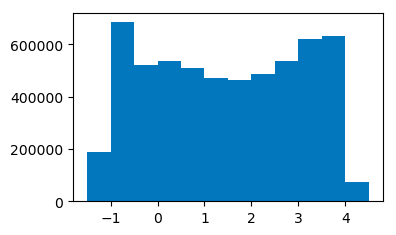

In [6]:
print("Min Max", table_byevent_proba.logit.min(), table_byevent_proba.logit.max())
logit_bins = np.arange(-1.5, 4.5 + 0.001, 0.5)

fig, ax = plt.subplots(1, 1, figsize=(4, 2.5), dpi=100)
ax.hist(
    table_byevent_proba.logit, 
    bins=logit_bins,
    color=viz.PALETTE['blue'],
    label=None
)
plt.show()

In [7]:
table_byevent_proba['logit_bin'] = pd.cut(table_byevent_proba.logit, bins=logit_bins)

In [8]:
# transforms densities so that it does not count the central event, only context (only neighbours)
table_byevent_proba['c10_neighbours'] = table_byevent_proba['c10_density_real']
table_byevent_proba.loc[table_byevent_proba.category == 1, 'c10_neighbours'] -= 1

table_byevent_proba['c20_neighbours'] = table_byevent_proba['c20_density_real']
table_byevent_proba.loc[table_byevent_proba.category == 1, 'c20_neighbours'] -= 1

In [ ]:
# table_byevent_proba[table_byevent_proba.logit_bin == pd.Interval(4, 4.5)].frequency.mean()

In [ ]:
# add distance to mean frequency
# mean_frequency = 13.46
# table_byevent_proba['frequency_dev'] = np.abs(table_byevent_proba['frequency'] - mean_frequency)
# table_byevent_proba = table_byevent_proba.drop(columns='frequency_dev')

In [9]:
nonfeat_columns = ['subject_id', 'center_sample', 'prediction_part', 'category', 'probability', 'logit', 'logit_bin', 'age', 'female']
exclude_feat_columns = [
    'amplitude_rms',
    'c10_abs_sigma_power', 'c10_abs_sigma_power_masked',
    'c20_abs_sigma_power', 'c20_abs_sigma_power_masked',
    'c10_rel_sigma_power', 'c20_rel_sigma_power',
    'c10_density_all', 'c20_density_all',
    'c10_density_real', 'c20_density_real',
    'mean_power_0_2',
    'mean_power_2_4',
    'mean_power_4_8',
    'mean_power_8_10',
    'mean_power_16_30',
    'mean_power_4.5_30',
    'c10_rel_sigma_power_masked', 'c20_rel_sigma_power_masked',
    'c10_neighbours',
]
feat_columns = [col for col in table_byevent_proba.columns if col not in nonfeat_columns+exclude_feat_columns]
# feat_columns.append('c10_rel_sigma_power_masked')
feat_columns.append('c20_rel_sigma_power_masked')
feat_columns

['duration',
 'frequency',
 'amplitude_pp',
 'correlation',
 'covariance',
 'mean_power_11_16',
 'mean_power_11_16_relto_mean_power_0_2',
 'mean_power_11_16_relto_mean_power_2_4',
 'mean_power_11_16_relto_mean_power_4_8',
 'mean_power_11_16_relto_mean_power_8_10',
 'mean_power_11_16_relto_mean_power_16_30',
 'mean_power_11_16_relto_mean_power_4.5_30',
 'c20_neighbours',
 'c20_rel_sigma_power_masked']

In [11]:
power_names = [
    'mean_power_11_16',
    'mean_power_11_16_relto_mean_power_4.5_30',
    'mean_power_11_16_relto_mean_power_0_2',
    'mean_power_11_16_relto_mean_power_2_4',
    'mean_power_11_16_relto_mean_power_4_8',
    'mean_power_11_16_relto_mean_power_8_10',
    'mean_power_11_16_relto_mean_power_16_30',
    'c20_rel_sigma_power_masked',
]
for param_name in power_names:
    new_name = 'log_%s' % param_name
    table_byevent_proba[new_name] = np.log10(table_byevent_proba[param_name])

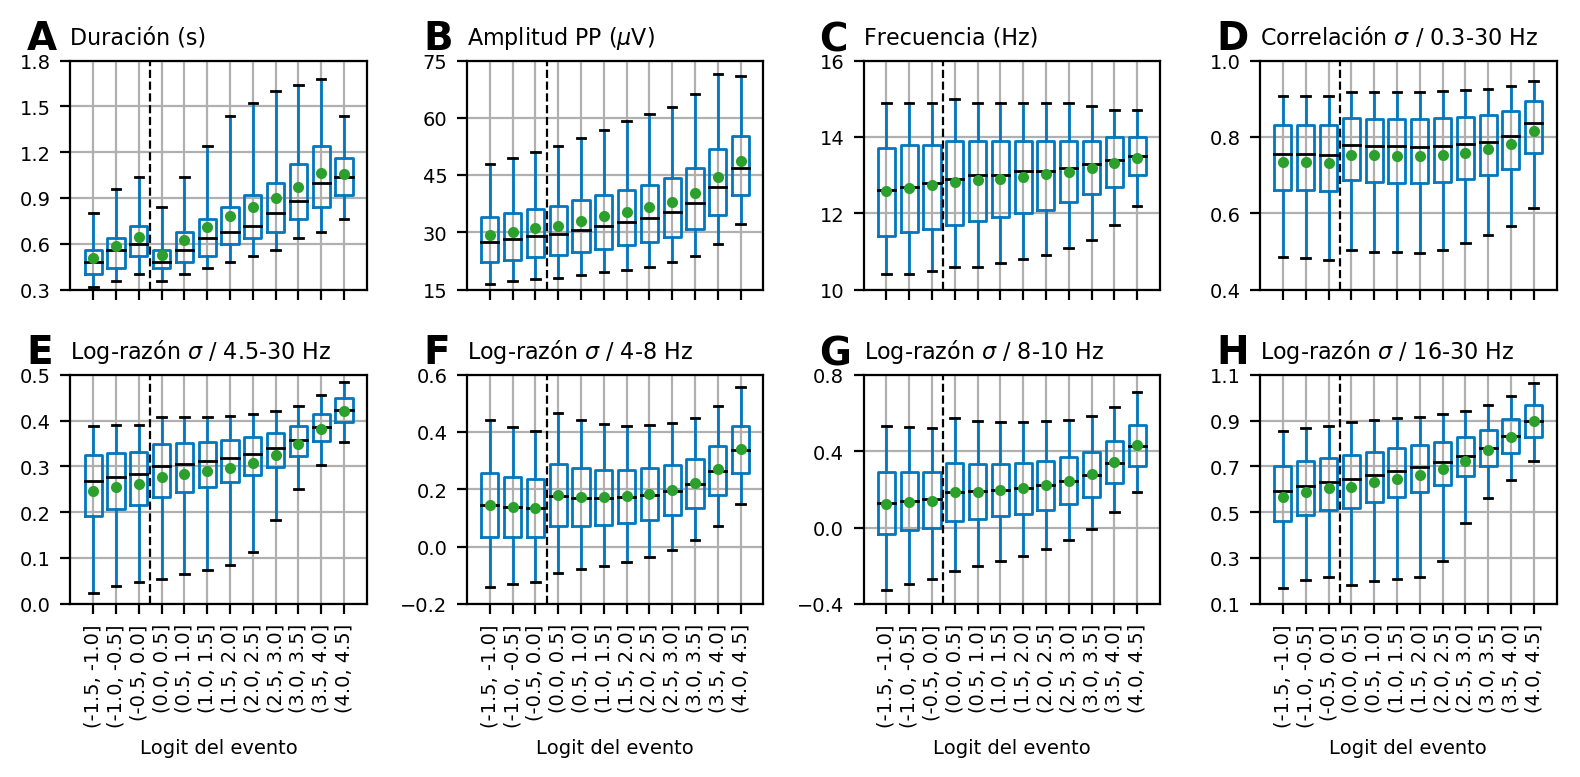

In [44]:
# Pretty
save_figure = True

param_names_map = {
    'duration': dict(label='Duración (s)', lim=(0.3, 1.8), res=0.3),
    'amplitude_pp': dict(label='Amplitud PP ($\mu$V)', lim=(15, 75), res=15),
    'frequency': dict(label='Frecuencia (Hz)', lim=(10, 16), res=2),
    'correlation': dict(label='Correlación $\sigma$ / 0.3-30 Hz', lim=(0.4, 1.0), res=0.2),
    'log_mean_power_11_16_relto_mean_power_4.5_30': dict(label='Log-razón $\sigma$ / 4.5-30 Hz', lim=(0, 0.5), res=0.1),
    'log_mean_power_11_16_relto_mean_power_4_8': dict(label='Log-razón $\sigma$ / 4-8 Hz', lim=(-0.2, 0.6), res=0.2),
    'log_mean_power_11_16_relto_mean_power_8_10': dict(label='Log-razón $\sigma$ / 8-10 Hz', lim=(-0.4, 0.8), res=0.4),
    'log_mean_power_11_16_relto_mean_power_16_30': dict(label='Log-razón $\sigma$ / 16-30 Hz', lim=(0.1, 1.1), res=0.2),
}
param_names = list(param_names_map.keys())

n_params = len(param_names)
n_cols = 4
n_rows = int(np.ceil(n_params / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 2 * n_rows), dpi=200, sharex=True)
axes = axes.flatten()

table_byevent_proba.boxplot(
    column=param_names,
    by="logit_bin", 
    ax=axes[:n_params], fontsize=8, rot=90,
    flierprops=dict(markersize=3, marker='o', markerfacecolor="k", alpha=0.25, markeredgewidth=0),
    boxprops=dict(color=viz.PALETTE['blue']),
    whiskerprops=dict(color=viz.PALETTE['blue']),
    medianprops=dict(color="k"),
    showfliers=False,
    showmeans=True,
    meanprops=dict(color="k", marker="o", markersize=3),
    widths=0.75,
    whis=[5, 95],
)
fig.suptitle('')
for i_ax, ax in enumerate(axes[:n_params]):
    ax.tick_params(labelsize=7)
    ax.set_title('')
    ax.set_xlabel('')
    label = param_names_map[param_names[i_ax]]['label']
    ax.set_title(label, fontsize=8, loc="left")
    ax.axvline(3.5, linewidth=0.8, color="k", linestyle="--")
    ax.set_xlim(0, len(logit_bins))
    ylim = param_names_map[param_names[i_ax]]['lim']
    yres = param_names_map[param_names[i_ax]]['res']
    ax.set_ylim(ylim)
    yticks = np.arange(ylim[0], ylim[1] + 0.001, yres)
    ax.set_yticks(yticks)

    ax.text(
        x=-0.15, y=1.05, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)

axes = axes.reshape((n_rows, n_cols))
for ax in axes[1, :]:
    ax.set_xlabel("Logit del evento", fontsize=7)


plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_nsrr_explain_simple_correlation"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.3)

plt.show()

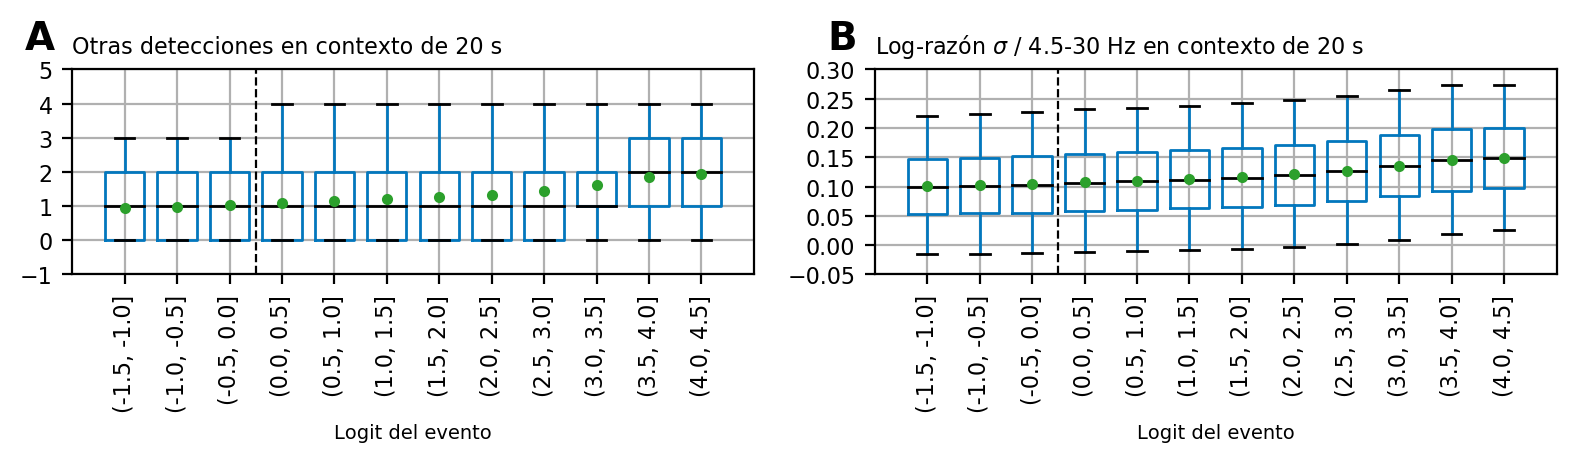

In [45]:
# internal plot, probably not going to thesis
save_figure = True

param_names_map = {
    'c20_neighbours': dict(label='Otras detecciones en contexto de 20 s', lim=(-1, 5), res=1),
    'log_c20_rel_sigma_power_masked': dict(label='Log-razón $\sigma$ / 4.5-30 Hz en contexto de 20 s', lim=(-0.05, 0.3), res=0.05),
}
param_names = list(param_names_map.keys())

fig, axes = plt.subplots(1, 2, figsize=(8, 2.5), dpi=200, sharex=True)
axes = axes.flatten()

table_byevent_proba.boxplot(
    column=param_names,
    by="logit_bin", 
    ax=axes[:n_params], fontsize=8, rot=90,
    flierprops=dict(markersize=3, marker='o', markerfacecolor="k", alpha=0.25, markeredgewidth=0),
    boxprops=dict(color=viz.PALETTE['blue']),
    whiskerprops=dict(color=viz.PALETTE['blue']),
    medianprops=dict(color="k"),
    showfliers=False,
    showmeans=True,
    meanprops=dict(color="k", marker="o", markersize=3),
    widths=0.75,
    whis=[5, 95],
)
fig.suptitle('')
for i_ax, ax in enumerate(axes):
    ax.tick_params(labelsize=8)
    ax.set_title('')
    ax.set_xlabel('')
    label = param_names_map[param_names[i_ax]]['label']
    ax.set_title(label, fontsize=8, loc="left")
    ax.axvline(3.5, linewidth=0.8, color="k", linestyle="--")
    ax.set_xlim(0, len(logit_bins))
    ylim = param_names_map[param_names[i_ax]]['lim']
    yres = param_names_map[param_names[i_ax]]['res']
    ax.set_ylim(ylim)
    yticks = np.arange(ylim[0], ylim[1] + 0.001, yres)
    ax.set_yticks(yticks)

    ax.text(
        x=-0.07, y=1.1, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)
    ax.set_xlabel("Logit del evento", fontsize=7)


plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_nsrr_explain_simple_context"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.3)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.3)

plt.show()

# Efecto del contexto

In [ ]:
noncontext_feats = [col for col in feat_columns if 'c10_' not in col and 'c20_' not in col]
window_duration = 20
fs = 200
window_size = int(window_duration * fs)

load_context_from_checkpoint = True

byevent_context_ckpt_path = os.path.join(
    RESULTS_PATH, 'predictions_nsrr_ss',
    'ckpt_20210716_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_ensemble_to_e1_n2_train_nsrr_ss',
    'v2_time',
    'table_byevent_context.csv'
)
if load_context_from_checkpoint:
    print("Loading from checkpoint")
    table_context = pd.read_csv(byevent_context_ckpt_path)
    # Change 64 bits dtypes to 32 bits to save memory
    int_cols = ["center_sample"]
    float_cols = [col for col in table_context.columns if col not in int_cols+["subject_id"]]
    table_context[int_cols] = table_context[int_cols].astype(np.int32)
    table_context[float_cols] = table_context[float_cols].astype(np.float32)
    print("Done.")
else:
    # solo contar como vecino si el centro esta dentro del contexto
    # solo considerar vecinos categoria 1
    subject_ids = np.unique(table_byevent_proba.subject_id)
    table_context = {'subject_id': [], 'center_sample': []}
    table_context.update({
        'c%davg_%s' % (window_duration, key): [] for key in noncontext_feats
    })
    for subject_id in subject_ids:
        subset = table_byevent_proba.loc[ 
            table_byevent_proba.subject_id == subject_id,  
            ['center_sample', 'category'] + noncontext_feats
        ]
        event_centers = subset.center_sample.values
        subset_real = subset[subset.category==1].drop(columns="category").set_index("center_sample")

        for event_center in event_centers:
            start_window = int(event_center - window_size // 2)
            end_window = int(start_window + window_size)
            neighbours = subset_real.loc[start_window:end_window+1]
            if event_center in neighbours.index:
                neighbours = neighbours.drop(event_center)
            # now we only have real neighbours, without considering event of interest
            if len(neighbours) > 0:
                mean_context = neighbours.mean()
            else:
                mean_context = {key: np.nan for key in noncontext_feats}
            # now save
            table_context['subject_id'].append(subject_id)
            table_context['center_sample'].append(event_center)
            for key in noncontext_feats:
                table_context['c%davg_%s' % (window_duration, key)].append(mean_context[key])
    table_context = pd.DataFrame.from_dict(table_context)
    
    print("Saving checkpoint")
    table_context.to_csv(byevent_context_ckpt_path, index=False)
    print("Done.") 

In [ ]:
# join tables
table_context = table_byevent_proba.merge(table_context, on=["subject_id", "center_sample"])
table_context

In [ ]:
table_context.dtypes